# MLP Fire Holdout (By-Fire Split)

This notebook trains a small MLP to predict whether the **center cell** will cross a GOES confidence threshold at time `t+1`, using the **3x3 neighborhood** features at time `t`.

- **Input (X)**: 3x3 patch (center + 8 neighbors), 7 variables per cell (63 features total).
- **Target (y)**: `1` iff `GOES_confidence_center(t+1) >= POSITIVE_THRESHOLD`, else `0`.
- **Split**: train on all fires except `TEST_FIRES`; evaluate only on `TEST_FIRES`.

Data layout expectation (same as `docs/neighbor_cell_confidence_regression.ipynb`):
- `data/multi_fire/<FireName>/*GOES*json`
- `data/multi_fire/<FireName>/rtma/rtma_manifest.json`


In [62]:
from pathlib import Path
import random

# Fire selection:
# - "all" => run on every fire in data/multi_fire/*
# - list => run only the named fires, e.g. ["Creek", "Dixie"]
FIRE_SELECTION = "all"

# --- By-fire split config (auto) ---
# The notebook automatically assigns fires to train/test (~70/30) using TEST_SPLIT_SEED.
# If you want a fixed test set, set TEST_FIRES_OVERRIDE to a list of fire names.
TRAIN_FIRE_FRACTION = 0.70
TEST_SPLIT_SEED = 1337
TEST_FIRES_OVERRIDE = None  # e.g., ["Dixie", "Kincade"]

# Optional: choose a validation set from the training-fire pool (by fire).
# - If VAL_FIRES_OVERRIDE is a list, those fires are used for validation.
# - If VAL_FIRES_OVERRIDE is None, we sample a fraction of train-pool fires.
VAL_FIRES_OVERRIDE = None  # e.g., ["Walker"]
VAL_FIRE_FRACTION = 0.20
VAL_SPLIT_SEED = 1337

# --- Task config ---
POSITIVE_THRESHOLD = 0.10

# Fixed reporting threshold (do not tune on test fires)
CLASSIFICATION_PROB_THRESHOLD = 0.50

# --- Training config ---
SEED = 1337
EPOCHS = 3
BATCH_SIZE = 8192
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
HIDDEN_DIMS = [256, 128, 64]
DROPOUT = 0.3
USE_BATCHNORM = True

# Optional safety knobs (default: full data)
MAX_HOURS_PER_FIRE = None        # e.g., 48
MAX_SAMPLES_PER_HOUR = None      # e.g., 200_000

print("cwd:", Path.cwd())
print("fire selection:", FIRE_SELECTION)
print("train fire fraction:", TRAIN_FIRE_FRACTION)
print("test split seed:", TEST_SPLIT_SEED)
print("test fires override:", TEST_FIRES_OVERRIDE)
print("val fires override:", VAL_FIRES_OVERRIDE)
print("val fire fraction:", VAL_FIRE_FRACTION)
print("val split seed:", VAL_SPLIT_SEED)
print("positive confidence threshold:", POSITIVE_THRESHOLD)
print("classification probability threshold:", CLASSIFICATION_PROB_THRESHOLD)
print("epochs:", EPOCHS)
print("batch size:", BATCH_SIZE)


cwd: /Users/seanmay/Desktop/Current Projects/wildfire-prediction/docs
fire selection: all
train fire fraction: 0.7
test split seed: 1337
test fires override: None
val fires override: None
val fire fraction: 0.2
val split seed: 1337
positive confidence threshold: 0.1
classification probability threshold: 0.5
epochs: 3
batch size: 8192


In [63]:
import json
import random
import hashlib
import math
import os
from datetime import datetime, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import Resampling, reproject

import torch
import torch.nn as nn


def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(SEED)


def pick_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    # Apple Silicon
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


DEVICE = pick_device()
print("torch:", torch.__version__)
print("device:", DEVICE)


torch: 2.5.1
device: mps


In [64]:
def parse_iso(value: str) -> datetime:
    if value.endswith("Z"):
        value = value[:-1] + "+00:00"
    return datetime.fromisoformat(value)


def normalize_time_str(value: str) -> str:
    dt = parse_iso(value)
    return dt.strftime("%Y-%m-%dT%H:00:00Z")


def affine_from_list(vals: list) -> rasterio.Affine:
    return rasterio.Affine(vals[0], vals[1], vals[2], vals[3], vals[4], vals[5])


def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "data").exists() and (p / "scripts").exists() and (p / "docs").exists():
            return p
    raise FileNotFoundError("Could not find repo root containing data/, scripts/, docs/.")


def load_goes_times(goes_meta: dict, goes_conf: np.ndarray):
    goes_time_steps = goes_meta.get("time_steps", [])
    goes_start = goes_meta.get("start_time")

    if goes_time_steps and isinstance(goes_time_steps[0], (int, float)):
        if not goes_start:
            raise ValueError("GOES time_steps are numeric and metadata.start_time is missing.")
        start_dt = parse_iso(goes_start)
        goes_time_steps = [
            (start_dt + timedelta(hours=int(i - 1))).strftime("%Y-%m-%dT%H:00:00Z")
            for i in goes_time_steps
        ]
    elif not goes_time_steps and goes_start:
        start_dt = parse_iso(goes_start)
        goes_time_steps = [
            (start_dt + timedelta(hours=i)).strftime("%Y-%m-%dT%H:00:00Z")
            for i in range(goes_conf.shape[0])
        ]
    else:
        goes_time_steps = [normalize_time_str(t) for t in goes_time_steps]

    if not goes_time_steps:
        raise ValueError("GOES metadata has no usable time_steps.")

    return goes_time_steps


def discover_fire_entries(repo_root: Path):
    base = repo_root / "data" / "multi_fire"
    if not base.exists():
        raise FileNotFoundError(f"Missing multi-fire directory: {base}")

    entries = []
    for fire_dir in sorted([d for d in base.iterdir() if d.is_dir()]):
        goes_candidates = sorted(fire_dir.glob("*GOES*json"))
        manifest_path = fire_dir / "rtma" / "rtma_manifest.json"
        if not goes_candidates or not manifest_path.exists():
            continue
        entries.append(
            {
                "fire_name": fire_dir.name,
                "goes_json": goes_candidates[0],
                "rtma_manifest": manifest_path,
            }
        )
    return entries


def select_fire_entries(entries, fire_selection):
    if fire_selection is None or fire_selection == "all":
        return entries

    if not isinstance(fire_selection, (list, tuple, set)):
        raise ValueError('FIRE_SELECTION must be "all" or a list/tuple/set of fire names.')

    wanted = {str(x) for x in fire_selection}
    selected = [e for e in entries if e["fire_name"] in wanted]
    found = {e["fire_name"] for e in selected}
    missing = sorted(wanted - found)
    if missing:
        raise ValueError(f"Unknown fire names in FIRE_SELECTION: {missing}")
    return selected


REPO_ROOT = find_repo_root(Path.cwd())


In [65]:
CELL_OFFSETS = [
    ("c", 0, 0),
    ("nw", -1, -1),
    ("n", -1, 0),
    ("ne", -1, 1),
    ("w", 0, -1),
    ("e", 0, 1),
    ("sw", 1, -1),
    ("s", 1, 0),
    ("se", 1, 1),
]

VAR_ORDER = ["GOES_conf", "TMP", "WIND", "SPFH", "ACPC01", "WDIR_sin", "WDIR_cos"]
RTMA_VARS_REQUIRED = ["TMP", "WIND", "WDIR", "SPFH", "ACPC01"]


def feature_names():
    names = []
    for n_name, _, _ in CELL_OFFSETS:
        for v in VAR_ORDER:
            names.append(f"{v}_{n_name}")
    return names


FEATURE_NAMES = feature_names()
N_FEATURES = len(FEATURE_NAMES)


def to_binary_target(y_continuous: np.ndarray, threshold: float) -> np.ndarray:
    return (y_continuous >= threshold).astype(np.int32)


def resolve_manifest_file_path(path_str: str, repo_root: Path, manifest_dir: Path) -> Path:
    p = Path(path_str).expanduser()
    if p.exists():
        return p

    parts = p.parts
    if "data" in parts:
        idx = parts.index("data")
        candidate = repo_root.joinpath(*parts[idx:])
        if candidate.exists():
            return candidate

    candidate = (manifest_dir / path_str).resolve()
    if candidate.exists():
        return candidate

    raise FileNotFoundError(f"Could not resolve RTMA part path: {path_str}")


def resample_stack(src_stack, src_transform, src_crs, dst_shape, dst_transform, dst_crs):
    bands = src_stack.shape[0]
    dst = np.empty((bands, dst_shape[0], dst_shape[1]), dtype=np.float32)
    for b in range(bands):
        reproject(
            source=src_stack[b],
            destination=dst[b],
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear,
        )
    return dst


def build_hour_samples(conf_t, conf_t1, rtma_hour):
    # Use only interior cells so center + all 8 neighbors exist.
    h, w = conf_t.shape
    if h < 3 or w < 3:
        return np.empty((0, N_FEATURES), dtype=np.float64), np.empty((0,), dtype=np.float64)

    y = conf_t1[1:-1, 1:-1].astype(np.float64)
    feat_blocks = []

    for _, dy, dx in CELL_OFFSETS:
        ys = slice(1 + dy, h - 1 + dy)
        xs = slice(1 + dx, w - 1 + dx)

        go_cell = conf_t[ys, xs].astype(np.float64)
        tmp_cell = rtma_hour["TMP"][ys, xs].astype(np.float64)
        wind_cell = rtma_hour["WIND"][ys, xs].astype(np.float64)
        spfh_cell = rtma_hour["SPFH"][ys, xs].astype(np.float64)
        precip_cell = rtma_hour["ACPC01"][ys, xs].astype(np.float64)
        wdir_deg_cell = rtma_hour["WDIR"][ys, xs].astype(np.float64)
        wdir_rad_cell = np.deg2rad(wdir_deg_cell)
        wdir_sin_cell = np.sin(wdir_rad_cell)
        wdir_cos_cell = np.cos(wdir_rad_cell)

        feat_blocks.extend([
            go_cell,
            tmp_cell,
            wind_cell,
            spfh_cell,
            precip_cell,
            wdir_sin_cell,
            wdir_cos_cell,
        ])

    X = np.stack(feat_blocks, axis=-1).reshape(-1, N_FEATURES)
    y = y.reshape(-1)

    valid = np.isfinite(y)
    valid &= np.isfinite(X).all(axis=1)

    if not valid.any():
        return np.empty((0, N_FEATURES), dtype=np.float64), np.empty((0,), dtype=np.float64)

    X = X[valid]
    y = y[valid]

    if MAX_SAMPLES_PER_HOUR is not None and X.shape[0] > MAX_SAMPLES_PER_HOUR:
        rng = np.random.default_rng(SEED)
        idx = rng.choice(X.shape[0], size=int(MAX_SAMPLES_PER_HOUR), replace=False)
        X = X[idx]
        y = y[idx]

    return X, y


def iter_aligned_hours_for_fire(
    goes_conf,
    goes_time_index,
    rtma_manifest,
    rtma_manifest_path: Path,
    goes_shape,
    goes_transform,
    goes_crs,
):
    rtma_vars = rtma_manifest["variables"]
    for req in RTMA_VARS_REQUIRED:
        if req not in rtma_vars:
            raise KeyError(f"RTMA manifest missing required variable: {req}")

    manifest_dir = rtma_manifest_path.parent
    rtma_files = rtma_manifest["files"]
    resolved_files = {
        var: [resolve_manifest_file_path(path, REPO_ROOT, manifest_dir) for path in rtma_files[var]]
        for var in rtma_vars
    }

    n_parts = len(resolved_files[rtma_vars[0]])
    for v in rtma_vars:
        if len(resolved_files[v]) != n_parts:
            raise ValueError("RTMA variable file lists do not have equal part counts.")

    parts = list(zip(*[resolved_files[v] for v in rtma_vars]))
    rtma_time_steps = [normalize_time_str(t) for t in rtma_manifest["time_steps"]]

    rtma_time_ptr = 0

    for part_paths in parts:
        rtma_arrays = {}
        rtma_transform = None
        rtma_crs = None
        band_count = None

        for var, part_path in zip(rtma_vars, part_paths):
            with rasterio.open(part_path) as ds:
                if rtma_transform is None:
                    rtma_transform = ds.transform
                    rtma_crs = ds.crs
                    band_count = ds.count
                rtma_arrays[var] = ds.read().astype("float32")

        if band_count is None:
            continue

        resampled = {}
        for var in rtma_vars:
            resampled[var] = resample_stack(
                rtma_arrays[var],
                rtma_transform,
                rtma_crs,
                goes_shape,
                goes_transform,
                goes_crs,
            )

        for local_idx in range(band_count):
            global_idx = rtma_time_ptr + local_idx
            if global_idx >= len(rtma_time_steps):
                break

            time_str = rtma_time_steps[global_idx]
            if time_str not in goes_time_index:
                continue

            t = goes_time_index[time_str]
            if t + 1 >= goes_conf.shape[0]:
                continue

            rtma_hour = {var: resampled[var][local_idx] for var in RTMA_VARS_REQUIRED}
            yield t, rtma_hour

        rtma_time_ptr += band_count


def iter_fire_hour_samples(entry):
    with Path(entry["goes_json"]).open("r", encoding="utf-8") as f:
        goes_json_local = json.load(f)
    with Path(entry["rtma_manifest"]).open("r", encoding="utf-8") as f:
        rtma_manifest_local = json.load(f)

    goes_conf_local = np.array(goes_json_local["data"], dtype=np.float32)
    goes_meta_local = goes_json_local["metadata"]
    goes_transform_local = affine_from_list(goes_meta_local["geo_transform"])
    goes_crs_local = goes_meta_local.get("crs")
    goes_shape_local = tuple(goes_meta_local["grid_shape"])
    goes_times_local = load_goes_times(goes_meta_local, goes_conf_local)
    goes_time_index_local = {t: i for i, t in enumerate(goes_times_local)}

    hours_yielded = 0
    for t, rtma_hour in iter_aligned_hours_for_fire(
        goes_conf_local,
        goes_time_index_local,
        rtma_manifest_local,
        Path(entry["rtma_manifest"]),
        goes_shape_local,
        goes_transform_local,
        goes_crs_local,
    ):
        X_hour, y_hour_cont = build_hour_samples(goes_conf_local[t], goes_conf_local[t + 1], rtma_hour)
        if X_hour.shape[0] == 0:
            continue
        y_hour = to_binary_target(y_hour_cont, POSITIVE_THRESHOLD)
        yield entry["fire_name"], t, X_hour, y_hour

        hours_yielded += 1
        if MAX_HOURS_PER_FIRE is not None and hours_yielded >= MAX_HOURS_PER_FIRE:
            break


print("feature count:", N_FEATURES)
print("first 10 feature names:", FEATURE_NAMES[:10])


feature count: 63
first 10 feature names: ['GOES_conf_c', 'TMP_c', 'WIND_c', 'SPFH_c', 'ACPC01_c', 'WDIR_sin_c', 'WDIR_cos_c', 'GOES_conf_nw', 'TMP_nw', 'WIND_nw']


In [66]:
all_fire_entries = discover_fire_entries(REPO_ROOT)
fire_entries = select_fire_entries(all_fire_entries, FIRE_SELECTION)

available = [e["fire_name"] for e in all_fire_entries]
selected = [e["fire_name"] for e in fire_entries]

print("available fires:", available)
print("selected fires:", selected)

if len(fire_entries) < 2:
    raise RuntimeError("Need at least 2 fires to do a train/test split.")

# Choose test fires (either override list, or deterministic random split)
all_names = [e["fire_name"] for e in fire_entries]

if TEST_FIRES_OVERRIDE is not None:
    missing = sorted(set(TEST_FIRES_OVERRIDE) - set(all_names))
    if missing:
        raise RuntimeError(f"TEST_FIRES_OVERRIDE not in selected fires: {missing}")
    TEST_FIRES = sorted(list(TEST_FIRES_OVERRIDE))
else:
    if not (0.0 < TRAIN_FIRE_FRACTION < 1.0):
        raise ValueError("TRAIN_FIRE_FRACTION must be between 0 and 1.")

    rng = random.Random(TEST_SPLIT_SEED)
    shuffled = all_names[:]
    rng.shuffle(shuffled)

    n_train_target = int(round(len(shuffled) * TRAIN_FIRE_FRACTION))
    n_train = max(1, min(len(shuffled) - 1, n_train_target))
    n_test = len(shuffled) - n_train

    TEST_FIRES = sorted(shuffled[:n_test])

# Training pool (train + val)
train_pool_entries = [e for e in fire_entries if e["fire_name"] not in set(TEST_FIRES)]
train_pool_names = [e["fire_name"] for e in train_pool_entries]

# Validation selection
if VAL_FIRES_OVERRIDE is not None:
    missing_val = sorted(set(VAL_FIRES_OVERRIDE) - set(train_pool_names))
    if missing_val:
        raise RuntimeError(f"VAL_FIRES_OVERRIDE not in training pool: {missing_val}")
    val_names = sorted(list(VAL_FIRES_OVERRIDE))
else:
    if not (0.0 < VAL_FIRE_FRACTION < 1.0):
        raise ValueError("VAL_FIRE_FRACTION must be between 0 and 1 when VAL_FIRES_OVERRIDE is None.")
    rng = random.Random(VAL_SPLIT_SEED)
    shuffled = train_pool_names[:]
    rng.shuffle(shuffled)
    n_val = max(1, int(round(len(shuffled) * VAL_FIRE_FRACTION)))
    val_names = sorted(shuffled[:n_val])

val_entries = [e for e in train_pool_entries if e["fire_name"] in set(val_names)]
train_entries = [e for e in train_pool_entries if e["fire_name"] not in set(val_names)]
test_entries = [e for e in fire_entries if e["fire_name"] in set(TEST_FIRES)]

print("train fires:", [e["fire_name"] for e in train_entries])
print("val fires:", [e["fire_name"] for e in val_entries])
print("test fires:", [e["fire_name"] for e in test_entries])
print("split sizes (fires): train=%d val=%d test=%d" % (len(train_entries), len(val_entries), len(test_entries)))

if not train_entries:
    raise RuntimeError("No training fires after split (train_entries is empty).")
if not val_entries:
    raise RuntimeError("No validation fires after split (val_entries is empty).")
if not test_entries:
    raise RuntimeError("No test fires after split (test_entries is empty).")


available fires: ['Antelope', 'August_Complex', 'Beckwourth_Complex', 'Bobcat', 'CZU_Lightning_Complex', 'Caldor', 'Creek', 'Dixie', 'Dolan', 'Glass', 'July_Complex', 'KNP_Complex', 'Kincade', 'LNU_Lightning_Complex', 'McCash', 'McFarland', 'Monument', 'North_Complex', 'Red_Salmon_Complex', 'River_Complex', 'SCU_Lightning_Complex', 'SQF_Complex', 'Slater_and_Devil', 'Tamarack', 'W-5_Cold_Springs', 'Walker', 'Windy', 'Zogg']
selected fires: ['Antelope', 'August_Complex', 'Beckwourth_Complex', 'Bobcat', 'CZU_Lightning_Complex', 'Caldor', 'Creek', 'Dixie', 'Dolan', 'Glass', 'July_Complex', 'KNP_Complex', 'Kincade', 'LNU_Lightning_Complex', 'McCash', 'McFarland', 'Monument', 'North_Complex', 'Red_Salmon_Complex', 'River_Complex', 'SCU_Lightning_Complex', 'SQF_Complex', 'Slater_and_Devil', 'Tamarack', 'W-5_Cold_Springs', 'Walker', 'Windy', 'Zogg']
train fires: ['August_Complex', 'Glass', 'July_Complex', 'KNP_Complex', 'Kincade', 'LNU_Lightning_Complex', 'McFarland', 'North_Complex', 'Red_Sa

In [67]:
def welford_update(count: int, mean: np.ndarray, m2: np.ndarray, X: np.ndarray):
    # X: (n, d)
    X = X.astype(np.float64, copy=False)
    n = X.shape[0]
    if n == 0:
        return count, mean, m2

    batch_mean = X.mean(axis=0)
    batch_m2 = ((X - batch_mean) ** 2).sum(axis=0)

    if count == 0:
        return n, batch_mean, batch_m2

    delta = batch_mean - mean
    total = count + n
    new_mean = mean + delta * (n / total)
    new_m2 = m2 + batch_m2 + (delta ** 2) * (count * n / total)
    return total, new_mean, new_m2


# Pass A: compute normalization stats + class balance on TRAIN fires only.
count = 0
mean = np.zeros((N_FEATURES,), dtype=np.float64)
m2 = np.zeros((N_FEATURES,), dtype=np.float64)

train_pos = 0
train_neg = 0
train_samples = 0
hours_used = 0

for entry in train_entries:
    for fire_name, t, X_hour, y_hour in iter_fire_hour_samples(entry):
        hours_used += 1
        train_samples += int(y_hour.shape[0])
        train_pos += int(y_hour.sum())
        train_neg += int(y_hour.shape[0] - y_hour.sum())

        count, mean, m2 = welford_update(count, mean, m2, X_hour)

if count < 2:
    raise RuntimeError("Not enough training samples to compute normalization stats.")

var = m2 / (count - 1)
std = np.sqrt(np.maximum(var, 1e-12))

pos_weight_value = (train_neg / max(train_pos, 1))

print("training hours used:", hours_used)
print("training samples:", train_samples)
print("training positives:", train_pos)
print("training negatives:", train_neg)
print("training pos rate:", train_pos / max(train_samples, 1))
print("pos_weight (neg/pos):", pos_weight_value)


training hours used: 11069
training samples: 72128728
training positives: 203899
training negatives: 71924829
training pos rate: 0.002826876414623588
pos_weight (neg/pos): 352.74733569070963


In [68]:
class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden_dims: list[int], dropout: float, use_batchnorm: bool):
        super().__init__()
        layers: list[nn.Module] = []
        prev = in_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            if dropout and dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)





model = MLP(N_FEATURES, HIDDEN_DIMS, DROPOUT, USE_BATCHNORM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print(model)


MLP(
  (net): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [69]:
def batch_iter(n_rows: int, batch_size: int):
    for start in range(0, n_rows, batch_size):
        end = min(n_rows, start + batch_size)
        yield start, end


def logits_to_pred(logits: torch.Tensor, prob_threshold: float) -> torch.Tensor:
    probs = torch.sigmoid(logits)
    return (probs >= prob_threshold).to(torch.int32)


# Train (streaming over hours)
model.train()

for epoch in range(1, EPOCHS + 1):
    epoch_loss = 0.0
    epoch_batches = 0

    tp = fp = fn = tn = 0

    for entry in train_entries:
        for fire_name, t, X_hour, y_hour in iter_fire_hour_samples(entry):
            Xn = (X_hour - mean) / std

            y_np = y_hour.astype(np.float32, copy=False)
            n_rows = Xn.shape[0]

            for start, end in batch_iter(n_rows, BATCH_SIZE):
                xb = torch.from_numpy(Xn[start:end]).to(device=DEVICE, dtype=torch.float32)
                yb = torch.from_numpy(y_np[start:end]).to(device=DEVICE, dtype=torch.float32).unsqueeze(1)

                optimizer.zero_grad(set_to_none=True)
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                epoch_loss += float(loss.detach().cpu())
                epoch_batches += 1

                with torch.no_grad():
                    pred = logits_to_pred(logits, CLASSIFICATION_PROB_THRESHOLD)
                    y_int = yb.to(torch.int32)
                    tp += int(((pred == 1) & (y_int == 1)).sum().cpu())
                    fp += int(((pred == 1) & (y_int == 0)).sum().cpu())
                    fn += int(((pred == 0) & (y_int == 1)).sum().cpu())
                    tn += int(((pred == 0) & (y_int == 0)).sum().cpu())

    avg_loss = epoch_loss / max(epoch_batches, 1)
    acc = (tp + tn) / max(tp + tn + fp + fn, 1)
    tpr = tp / max(tp + fn, 1)
    tnr = tn / max(tn + fp, 1)

    print(f"epoch {epoch}/{EPOCHS} avg_loss={avg_loss:.6f} acc={acc:.4f} tpr={tpr:.4f} tnr={tnr:.4f} TP={tp} FP={fp} FN={fn} TN={tn}")


epoch 1/3 avg_loss=0.392600 acc=0.9764 tpr=0.8680 tnr=0.9767 TP=176990 FP=1675426 FN=26909 TN=70249403
epoch 2/3 avg_loss=0.378161 acc=0.9843 tpr=0.8587 tnr=0.9847 TP=175084 FP=1100944 FN=28815 TN=70823885
epoch 3/3 avg_loss=0.374632 acc=0.9848 tpr=0.8582 tnr=0.9851 TP=174983 FP=1070389 FN=28916 TN=70854440


val positive rate (baseline precision at recall=1): 0.0030740218791624556
best threshold by F1 (VAL): 0.997
precision: 0.7751371345176388 recall: 0.7446247930288491 f1: 0.7595746648173832


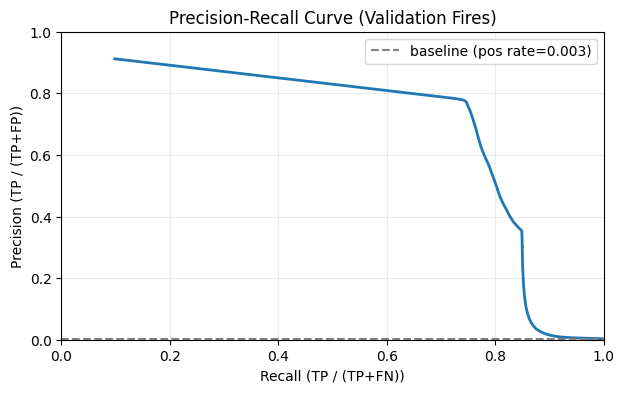

,threshold,precision,recall,f1,tp,fp,fn,tn
997,0.997,0.775137,0.744625,0.759575,61611,17873,21130,26815590
998,0.998,0.778732,0.739984,0.758863,61227,17397,21514,26816066
996,0.996,0.770653,0.746921,0.758602,61801,18392,20940,26815071
995,0.995,0.763814,0.748637,0.756149,61943,19154,20798,26814309
994,0.994,0.758369,0.749616,0.753967,62024,19762,20717,26813701
999,0.999,0.783020,0.726532,0.753719,60114,16658,22627,26816805
993,0.993,0.754433,0.750704,0.752564,62114,20218,20627,26813245
992,0.992,0.751693,0.751465,0.751579,62177,20539,20564,26812924
991,0.991,0.749239,0.752191,0.750712,62237,20830,20504,26812633
990,0.990,0.746754,0.752855,0.749792,62292,21125,20449,26812338


In [70]:
# Threshold selection on validation fires (by-fire split)
# We keep CLASSIFICATION_PROB_THRESHOLD at 0.5 for consistent reporting,
# but choose an operating threshold by maximizing F1 on VAL fires.

model.eval()

PR_THRESHOLDS = np.linspace(0.0, 1.0, 1001)

val_tp = np.zeros(PR_THRESHOLDS.shape[0], dtype=np.int64)
val_fp = np.zeros(PR_THRESHOLDS.shape[0], dtype=np.int64)
val_total_pos = 0
val_total_neg = 0

def batch_iter(n_rows: int, batch_size: int):
    for start in range(0, n_rows, batch_size):
        end = min(n_rows, start + batch_size)
        yield start, end

with torch.no_grad():
    for entry in val_entries:
        for fire_name, t, X_hour, y_hour in iter_fire_hour_samples(entry):
            Xn = (X_hour - mean) / std
            y_np = y_hour.astype(np.int32, copy=False)

            n_rows = Xn.shape[0]
            for start, end in batch_iter(n_rows, BATCH_SIZE):
                xb = torch.from_numpy(Xn[start:end]).to(device=DEVICE, dtype=torch.float32)
                logits = model(xb)
                probs = torch.sigmoid(logits).squeeze(1).detach().cpu().numpy()

                yb = y_np[start:end]
                pos = yb == 1
                val_total_pos += int(pos.sum())
                val_total_neg += int((~pos).sum())

                sweep_pred = probs[:, None] >= PR_THRESHOLDS[None, :]
                val_tp += (sweep_pred & pos[:, None]).sum(axis=0).astype(np.int64)
                val_fp += (sweep_pred & (~pos)[:, None]).sum(axis=0).astype(np.int64)

if val_total_pos == 0:
    raise RuntimeError("No positive samples in the validation set; cannot tune threshold by F1.")

val_fn = val_total_pos - val_tp
val_tn = val_total_neg - val_fp

val_precision = np.where((val_tp + val_fp) > 0, val_tp / (val_tp + val_fp), 1.0)
val_recall = val_tp / val_total_pos
val_f1 = np.where((val_precision + val_recall) > 0, 2 * val_precision * val_recall / (val_precision + val_recall), 0.0)

val_pr_df = pd.DataFrame({
    "threshold": PR_THRESHOLDS,
    "precision": val_precision,
    "recall": val_recall,
    "f1": val_f1,
    "tp": val_tp,
    "fp": val_fp,
    "fn": val_fn,
    "tn": val_tn,
})

val_best = val_pr_df.iloc[int(val_pr_df["f1"].idxmax())]
VAL_TUNED_THRESHOLD = float(val_best["threshold"])
val_baseline = val_total_pos / (val_total_pos + val_total_neg)

print("val positive rate (baseline precision at recall=1):", float(val_baseline))
print("best threshold by F1 (VAL):", VAL_TUNED_THRESHOLD)
print("precision:", float(val_best["precision"]), "recall:", float(val_best["recall"]), "f1:", float(val_best["f1"]))

val_plot_df = val_pr_df.sort_values("recall")
plt.figure(figsize=(7, 4))
plt.plot(val_plot_df["recall"], val_plot_df["precision"], linewidth=2)
plt.hlines(val_baseline, 0, 1, linestyles="dashed", colors="gray", label=f"baseline (pos rate={val_baseline:.3f})")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall (TP / (TP+FN))")
plt.ylabel("Precision (TP / (TP+FP))")
plt.title("Precision-Recall Curve (Validation Fires)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

val_pr_df.sort_values("f1", ascending=False).head(12)


test metrics @ fixed threshold: 0.5 {'n': 44841094, 'accuracy': 0.9951931815044477, 'precision': 0.3922577016809348, 'recall': 0.8565307862868838, 'tpr': 0.8565307862868838, 'tnr': 0.995647922735224, 'f1': 0.5380907990185049, 'tp': 125546, 'fp': 194514, 'fn': 21029, 'tn': 44500005}
test metrics @ tuned threshold: 0.997 {'n': 44841094, 'accuracy': 0.9985036047514808, 'precision': 0.7844752911867247, 'recall': 0.7476104383421457, 'tpr': 0.7476104383421457, 'tnr': 0.9993264051012608, 'f1': 0.7655993460536153, 'tp': 109581, 'fp': 30106, 'fn': 36994, 'tn': 44664413}
per-fire test metrics @ fixed:
Antelope {'n': 6656160, 'accuracy': 0.9979440097593808, 'precision': 0.3559929400438573, 'recall': 0.8019277108433734, 'tpr': 0.8019277108433734, 'tnr': 0.9981887404367721, 'f1': 0.4930918250175946, 'tp': 6656, 'fp': 12041, 'fn': 1644, 'tn': 6635819}
Beckwourth_Complex {'n': 2424240, 'accuracy': 0.99501947001947, 'precision': 0.46204097792734833, 'recall': 0.8857685009487666, 'tpr': 0.8857685009487

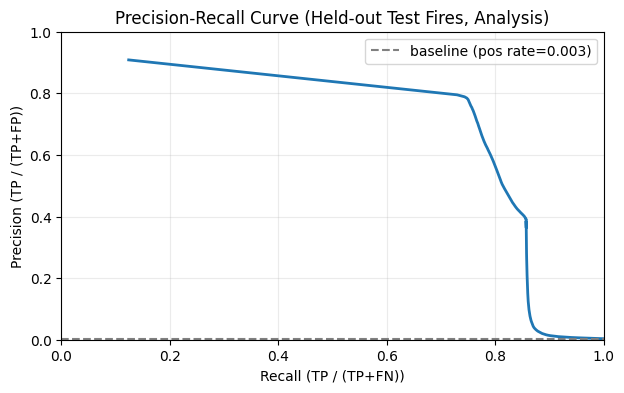

,threshold,precision,recall,f1,tp,fp,fn,tn
997,0.997,0.784475,0.747610,0.765599,109581,30106,36994,44664413
998,0.998,0.788760,0.743299,0.765355,108949,29178,37626,44665341
996,0.996,0.779713,0.749951,0.764542,109924,31056,36651,44663463
995,0.995,0.772754,0.751629,0.762045,110170,32398,36405,44662121
999,0.999,0.795112,0.729599,0.760948,106941,27557,39634,44666962
994,0.994,0.767524,0.752925,0.760155,110360,33427,36215,44661092
993,0.993,0.763751,0.753867,0.758777,110498,34180,36077,44660339
992,0.992,0.761148,0.754610,0.757865,110607,34709,35968,44659810
991,0.991,0.758805,0.755108,0.756952,110680,35181,35895,44659338
990,0.990,0.756835,0.755777,0.756306,110778,35592,35797,44658927


In [71]:
# Test evaluation at two thresholds:
# 1) fixed CLASSIFICATION_PROB_THRESHOLD (default 0.5)
# 2) VAL_TUNED_THRESHOLD selected by F1 on validation fires

def metrics_from_counts(tp, fp, fn, tn):
    n = tp + fp + fn + tn
    acc = (tp + tn) / max(n, 1)
    recall = tp / max(tp + fn, 1)
    tpr = recall
    tnr = tn / max(tn + fp, 1)
    precision = tp / max(tp + fp, 1)
    denom = (precision + recall)
    f1 = (2 * precision * recall / denom) if denom > 0 else 0.0
    return {"n": n, "accuracy": acc, "precision": precision, "recall": recall, "tpr": tpr, "tnr": tnr, "f1": f1, "tp": tp, "fp": fp, "fn": fn, "tn": tn}

def update_counts(counts: dict, pred: np.ndarray, yb: np.ndarray) -> None:
    tp = int(((pred == 1) & (yb == 1)).sum())
    fp = int(((pred == 1) & (yb == 0)).sum())
    fn = int(((pred == 0) & (yb == 1)).sum())
    tn = int(((pred == 0) & (yb == 0)).sum())
    counts["tp"] += tp
    counts["fp"] += fp
    counts["fn"] += fn
    counts["tn"] += tn

fixed = {"tp": 0, "fp": 0, "fn": 0, "tn": 0}
tuned = {"tp": 0, "fp": 0, "fn": 0, "tn": 0}
per_fire_fixed = {}
per_fire_tuned = {}

# Also compute a test PR curve for analysis (not used for tuning)
test_tp = np.zeros(PR_THRESHOLDS.shape[0], dtype=np.int64)
test_fp = np.zeros(PR_THRESHOLDS.shape[0], dtype=np.int64)
test_total_pos = 0
test_total_neg = 0

with torch.no_grad():
    for entry in test_entries:
        fire = entry["fire_name"]
        per_fire_fixed.setdefault(fire, {"tp": 0, "fp": 0, "fn": 0, "tn": 0})
        per_fire_tuned.setdefault(fire, {"tp": 0, "fp": 0, "fn": 0, "tn": 0})

        for fire_name, t, X_hour, y_hour in iter_fire_hour_samples(entry):
            Xn = (X_hour - mean) / std
            y_np = y_hour.astype(np.int32, copy=False)

            n_rows = Xn.shape[0]
            for start, end in batch_iter(n_rows, BATCH_SIZE):
                xb = torch.from_numpy(Xn[start:end]).to(device=DEVICE, dtype=torch.float32)
                logits = model(xb)
                probs = torch.sigmoid(logits).squeeze(1).detach().cpu().numpy()

                yb = y_np[start:end]
                pred_fixed = (probs >= CLASSIFICATION_PROB_THRESHOLD).astype(np.int32)
                pred_tuned = (probs >= VAL_TUNED_THRESHOLD).astype(np.int32)

                update_counts(fixed, pred_fixed, yb)
                update_counts(tuned, pred_tuned, yb)
                update_counts(per_fire_fixed[fire], pred_fixed, yb)
                update_counts(per_fire_tuned[fire], pred_tuned, yb)

                pos = yb == 1
                test_total_pos += int(pos.sum())
                test_total_neg += int((~pos).sum())
                sweep_pred = probs[:, None] >= PR_THRESHOLDS[None, :]
                test_tp += (sweep_pred & pos[:, None]).sum(axis=0).astype(np.int64)
                test_fp += (sweep_pred & (~pos)[:, None]).sum(axis=0).astype(np.int64)

fixed_metrics = metrics_from_counts(**fixed)
tuned_metrics = metrics_from_counts(**tuned)

print("test metrics @ fixed threshold:", CLASSIFICATION_PROB_THRESHOLD, fixed_metrics)
print("test metrics @ tuned threshold:", VAL_TUNED_THRESHOLD, tuned_metrics)

print("per-fire test metrics @ fixed:")
for fire in sorted(per_fire_fixed):
    print(fire, metrics_from_counts(**per_fire_fixed[fire]))

print("per-fire test metrics @ tuned:")
for fire in sorted(per_fire_tuned):
    print(fire, metrics_from_counts(**per_fire_tuned[fire]))

if test_total_pos == 0:
    raise RuntimeError("No positive samples in the held-out test set; cannot compute precision/recall.")

test_fn = test_total_pos - test_tp
test_tn = test_total_neg - test_fp

test_precision = np.where((test_tp + test_fp) > 0, test_tp / (test_tp + test_fp), 1.0)
test_recall = test_tp / test_total_pos
test_f1 = np.where((test_precision + test_recall) > 0, 2 * test_precision * test_recall / (test_precision + test_recall), 0.0)

test_pr_df = pd.DataFrame({
    "threshold": PR_THRESHOLDS,
    "precision": test_precision,
    "recall": test_recall,
    "f1": test_f1,
    "tp": test_tp,
    "fp": test_fp,
    "fn": test_fn,
    "tn": test_tn,
})

test_best = test_pr_df.iloc[int(test_pr_df["f1"].idxmax())]
test_baseline = test_total_pos / (test_total_pos + test_total_neg)

print("test positive rate (baseline precision at recall=1):", float(test_baseline))
print("best threshold by F1 (TEST, analysis-only):", float(test_best["threshold"]))
print("precision:", float(test_best["precision"]), "recall:", float(test_best["recall"]), "f1:", float(test_best["f1"]))

plot_df = test_pr_df.sort_values("recall")
plt.figure(figsize=(7, 4))
plt.plot(plot_df["recall"], plot_df["precision"], linewidth=2)
plt.hlines(test_baseline, 0, 1, linestyles="dashed", colors="gray", label=f"baseline (pos rate={test_baseline:.3f})")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall (TP / (TP+FN))")
plt.ylabel("Precision (TP / (TP+FP))")
plt.title("Precision-Recall Curve (Held-out Test Fires, Analysis)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

test_pr_df.sort_values("f1", ascending=False).head(12)


In [72]:
# Save report
out_dir = REPO_ROOT / "data" / "analysis" / "mlp_fire_holdout"
out_dir.mkdir(parents=True, exist_ok=True)

trapz = getattr(np, "trapezoid", None)
if trapz is None:
    trapz = np.trapz

val_ap = float(trapz(val_plot_df["precision"].to_numpy(), val_plot_df["recall"].to_numpy()))
test_plot_df = test_pr_df.sort_values("recall")
test_ap = float(trapz(test_plot_df["precision"].to_numpy(), test_plot_df["recall"].to_numpy()))

report = {
    "model": "mlp_pytorch",
    "config": {
        "fire_selection": FIRE_SELECTION,
        "test_fires": TEST_FIRES,
        "train_fire_fraction": TRAIN_FIRE_FRACTION,
        "test_split_seed": TEST_SPLIT_SEED,
        "test_fires_override": TEST_FIRES_OVERRIDE,
        "val_fires_override": VAL_FIRES_OVERRIDE,
        "val_fire_fraction": VAL_FIRE_FRACTION,
        "val_split_seed": VAL_SPLIT_SEED,
        "positive_threshold": POSITIVE_THRESHOLD,
        "classification_prob_threshold": CLASSIFICATION_PROB_THRESHOLD,
        "seed": SEED,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "hidden_dims": HIDDEN_DIMS,
        "dropout": DROPOUT,
        "use_batchnorm": USE_BATCHNORM,
        "max_hours_per_fire": MAX_HOURS_PER_FIRE,
        "max_samples_per_hour": MAX_SAMPLES_PER_HOUR,
        "n_features": N_FEATURES,
        "feature_names": FEATURE_NAMES,
        "pr_threshold_count": int(PR_THRESHOLDS.shape[0]),
    },
    "train": {
        "fires": [e["fire_name"] for e in train_entries],
        "samples": int(train_samples),
        "positives": int(train_pos),
        "negatives": int(train_neg),
        "pos_rate": float(train_pos / max(train_samples, 1)),
        "pos_weight": float(pos_weight_value),
    },
    "val": {
        "fires": [e["fire_name"] for e in val_entries],
        "baseline_pos_rate": float(val_baseline),
        "best_threshold_by_f1": float(VAL_TUNED_THRESHOLD),
        "best_precision": float(val_best["precision"]),
        "best_recall": float(val_best["recall"]),
        "best_f1": float(val_best["f1"]),
        "approx_ap": float(val_ap),
        "top_by_f1": val_pr_df.sort_values("f1", ascending=False).head(12).to_dict(orient="records"),
    },
    "test": {
        "fires": [e["fire_name"] for e in test_entries],
        "metrics_fixed_threshold": {"threshold": float(CLASSIFICATION_PROB_THRESHOLD), **fixed_metrics},
        "metrics_tuned_threshold": {"threshold": float(VAL_TUNED_THRESHOLD), **tuned_metrics},
        "per_fire_fixed": {f: metrics_from_counts(**c) for f, c in per_fire_fixed.items()},
        "per_fire_tuned": {f: metrics_from_counts(**c) for f, c in per_fire_tuned.items()},
        "analysis_threshold_sweep": {
            "baseline_pos_rate": float(test_baseline),
            "best_threshold_by_f1": float(test_best["threshold"]),
            "best_precision": float(test_best["precision"]),
            "best_recall": float(test_best["recall"]),
            "best_f1": float(test_best["f1"]),
            "approx_ap": float(test_ap),
            "top_by_f1": test_pr_df.sort_values("f1", ascending=False).head(12).to_dict(orient="records"),
        },
    },
}

report_path = out_dir / "report.json"
with report_path.open("w", encoding="utf-8") as f:
    json.dump(report, f, indent=2)

print("saved:", report_path)


saved: /Users/seanmay/Desktop/Current Projects/wildfire-prediction/data/analysis/mlp_fire_holdout/report.json
